In [2]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [4]:
fpath = './data/phase2_ground_truth.hdf'
df = pd.read_hdf(fpath)


In [5]:
df

,timestamp,value,label,KPI ID
107717,1482940800,0.048066,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107718,1482940860,0.010651,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107719,1482940920,0.014996,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107720,1482940980,0.039722,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107721,1482941040,0.022452,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
...,...,...,...,...
295409,1508984160,34.940000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
295410,1508984220,35.200000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
295411,1508984280,33.020000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
295412,1508984340,35.150000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114


In [6]:
uuids = df.groupby('KPI ID').size()#.loc[lambda x: x>140000].sort_values().index.values

1. Drop time series with 5-min interval
2. Missing statuses are filled with adjacent periods (24 hour). Specifically, when the missing duration is less than or equal to M=7 time units, the linear interpolation is performed by filling the missing statuses with the adjacent statuses. When the missing duration is greater than M time units, the linear interpolation is performed with the status of the same time slot from the adjacent periods as shown in Fig. 2. 

![title](img/imp.png)

In [19]:
def plot_anomaly(df, num):
    t_n = df[df.label==0].index.values
    v_n = df[df.label==0].value.values
    t_a = df[df.label==1].index.values
    v_a = df[df.label==1].value.values

    fig, ax = plt.subplots(figsize=(16, 4))

    ax.plot(t_n, v_n, '.')
    ax.plot(t_a, v_a, 'o')

    ax.set(xlabel='time (s)', ylabel='value',
           title=f'./data/{num}.csv')
    ax.grid()

    fig.savefig(f"./data/{num}.png")
    plt.show()

    
def check_missing_timestamp(df):
    missing_intervals = []
    missing_intervals_len = []
    for i in range(0, len(df)-1, 2):
        if df.timestamp.values[i] != df.timestamp.values[i+1] - 60:
            missing_intervals.append(i)
            missing_intervals_len.append((df.timestamp.values[i+1] - df.timestamp.values[i]) // 60)
    return missing_intervals, missing_intervals_len


In [37]:
def interpolate(ts, label, kpi_id, a, b):
    if a < 0: #np.isnan(ts[a]):
        return ts[b], label[b], kpi_id[b]
    elif b >= len(ts): #np.isnan(ts[b]):
        return ts[a], label[a], kpi_id[a]
    else:
        return (ts[a] + ts[b]) / 2, max(label[a], label[b]), kpi_id[a]



def impute(df, m=7, period=60*24):
    #missing_intervals, missing_intervals_len = check_missing_timestamp(df)
    v = df.value.values
    label = df.label.values
    kpi = df['KPI ID'].values
    for i in range(len(v)):
            if not np.isnan(v[i]):
                continue
                
            # find nan window len
            i_next_not_null = i
            while i_next_not_null < len(v):
                i_next_not_null += 1
                if not np.isnan(v[i_next_not_null]):
                    break
                
            if i_next_not_null - i <= m:
                v[i], label[i], kpi[i]  = interpolate(v, label, kpi, i-1, i_next_not_null)
            else:
                #print(f'{i}')
                i_prev_period = i - period
                i_next_period = i + period
                while i_next_period < len(v):
                    if not np.isnan(v[i_next_period]):
                        break
                    i_next_period += period
                #print(f'start {i_prev_period} nans: {i}..{i_next_not_null}, len: {i_next_not_null - i}')
                for step in range(i_next_not_null - i):
                    try:
                        v[i+step], label[i+step], kpi[i+step] = interpolate(v, label, kpi, i_prev_period+step, i_next_period+step)
                    except:
                        break
                i = i_next_not_null + step
    df['value'] = v
    df['label'] = label
    df['KPI ID'] = kpi
    return df

0: 05f10d3a-239c-3bef-9bdc-a2feeb0037aa period: 60 sec
Total missing values: 357/149130
Longest missing interval: 2, 5, avreage interval 2.0517241379310347


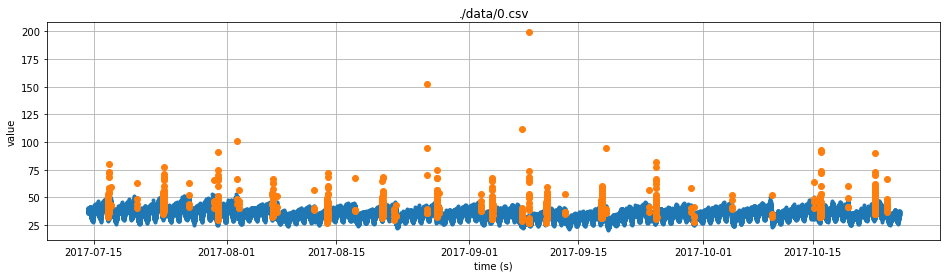

Total missing values: 0


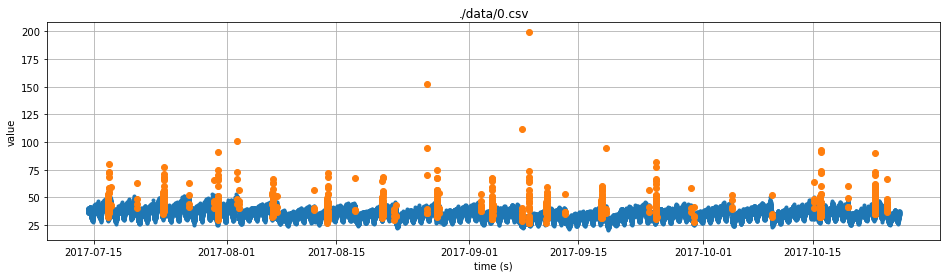

1: 0efb375b-b902-3661-ab23-9a0bb799f4e3 period: 300 sec
2: 1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0 period: 60 sec
Total missing values: 360/149156
Longest missing interval: 2, 7, avreage interval 2.0809248554913293


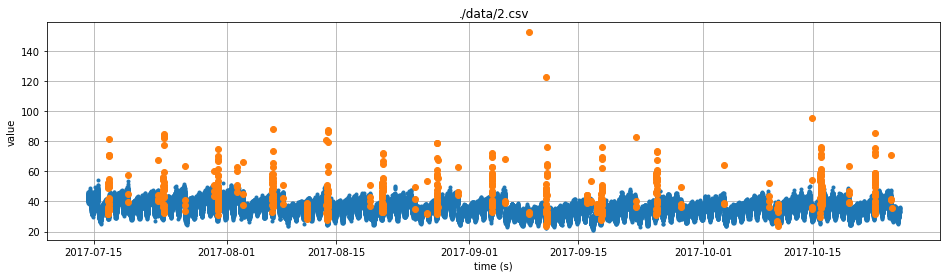

Total missing values: 0


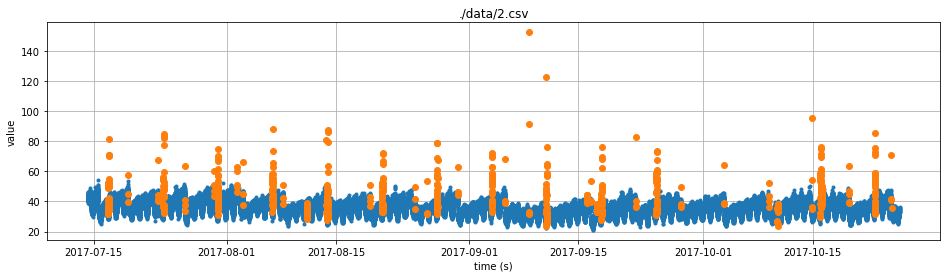

3: 301c70d8-1630-35ac-8f96-bc1b6f4359ea period: 300 sec
4: 42d6616d-c9c5-370a-a8ba-17ead74f3114 period: 60 sec
Total missing values: 349/149161
Longest missing interval: 2, 4, avreage interval 2.0409356725146197


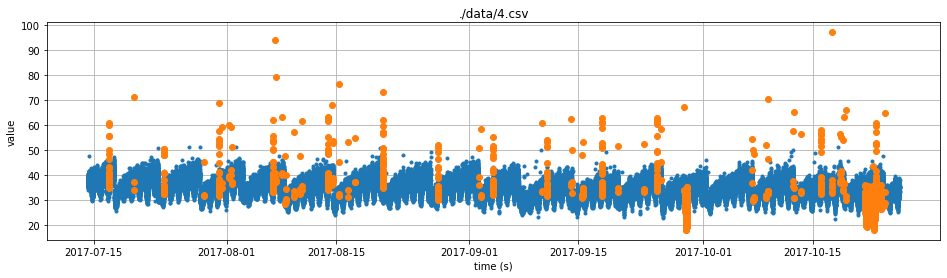

Total missing values: 0


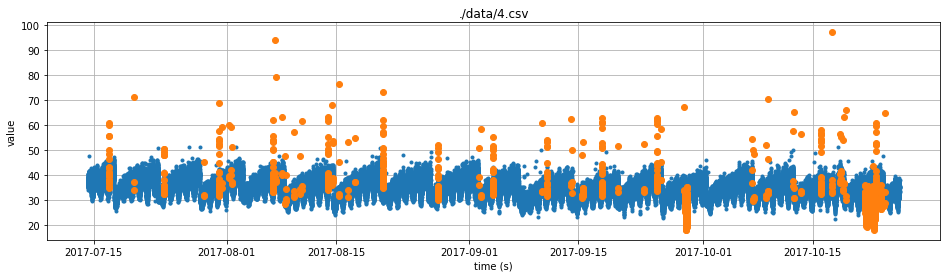

5: 43115f2a-baeb-3b01-96f7-4ea14188343c period: 60 sec
Total missing values: 48/110629
Longest missing interval: 2, 6, avreage interval 2.526315789473684


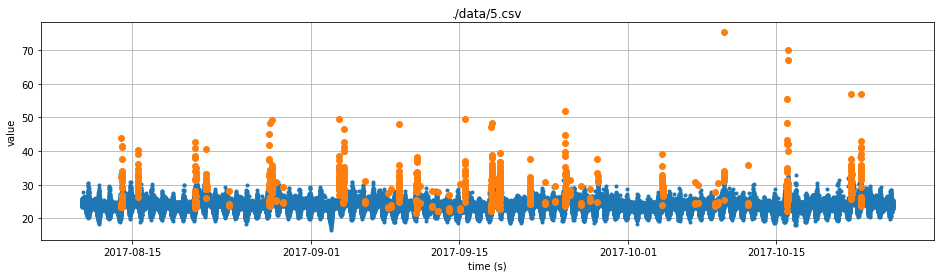

Total missing values: 0


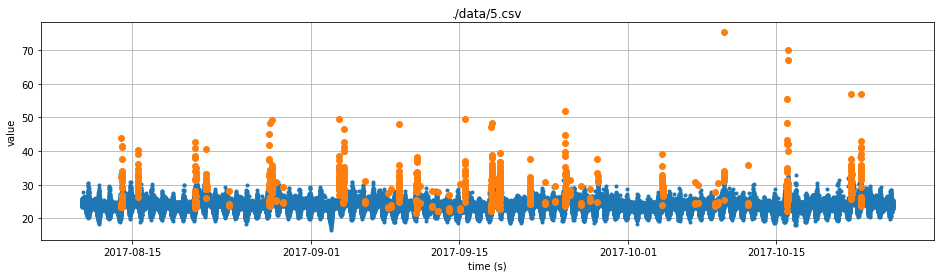

6: 431a8542-c468-3988-a508-3afd06a218da period: 60 sec
Total missing values: 16455/111566
Longest missing interval: 2, 5421, avreage interval 82.68844221105527


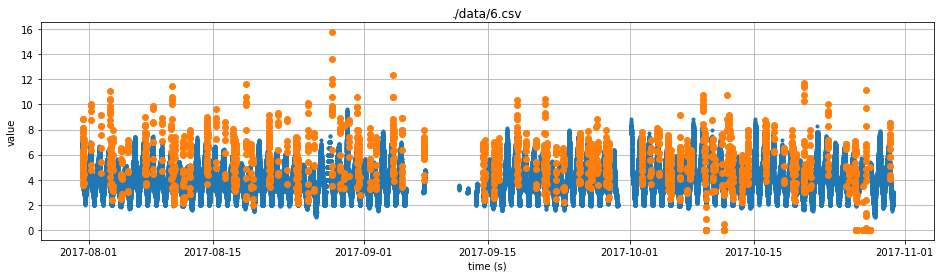

Total missing values: 0


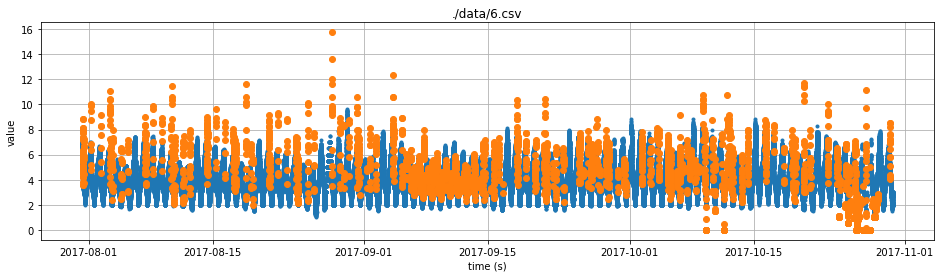

7: 4d2af31a-9916-3d9f-8a8e-8a268a48c095 period: 60 sec
Total missing values: 2124/111370
Longest missing interval: 2, 1301, avreage interval 30.782608695652176


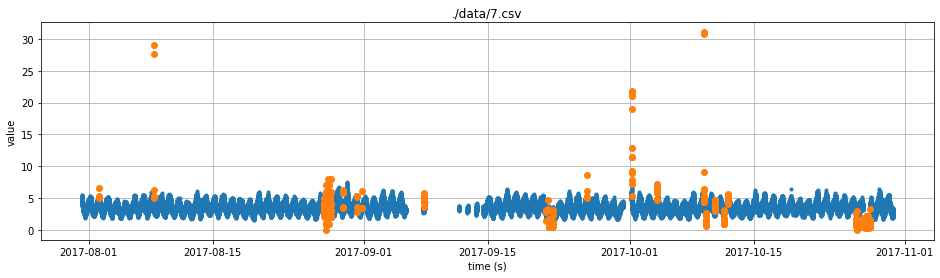

Total missing values: 0


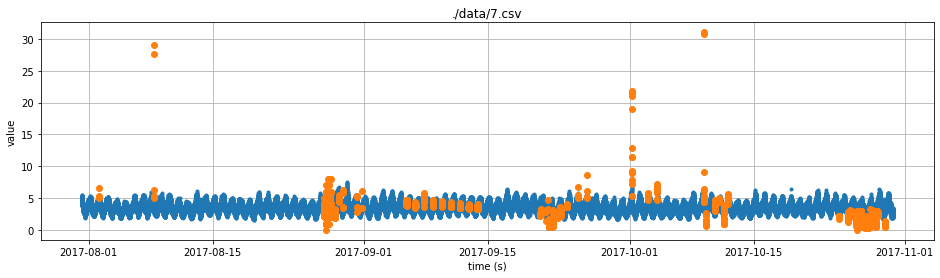

8: 54350a12-7a9d-3ca8-b81f-f886b9d156fd period: 300 sec
9: 55f8b8b8-b659-38df-b3df-e4a5a8a54bc9 period: 60 sec
Total missing values: 396/149133
Longest missing interval: 2, 6, avreage interval 2.106382978723404


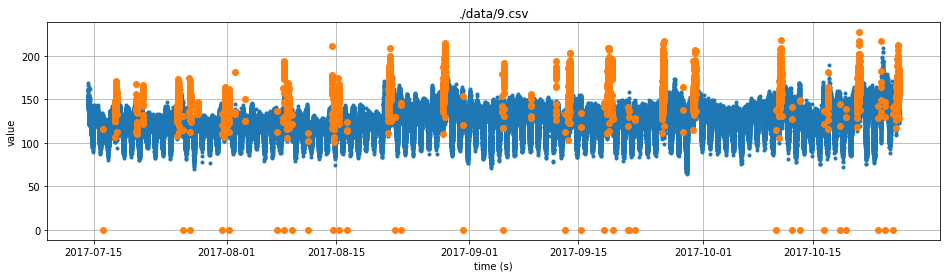

Total missing values: 0


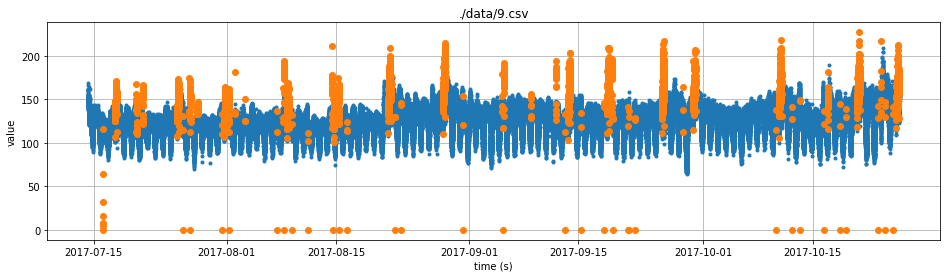

10: 57051487-3a40-3828-9084-a12f7f23ee38 period: 60 sec
Total missing values: 581/111679
Longest missing interval: 2, 53, avreage interval 12.361702127659575


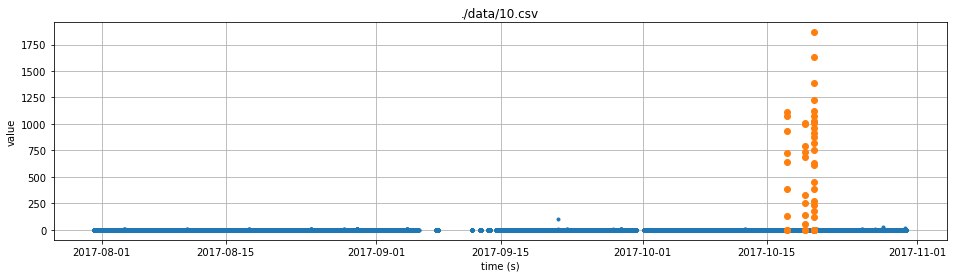

Total missing values: 0


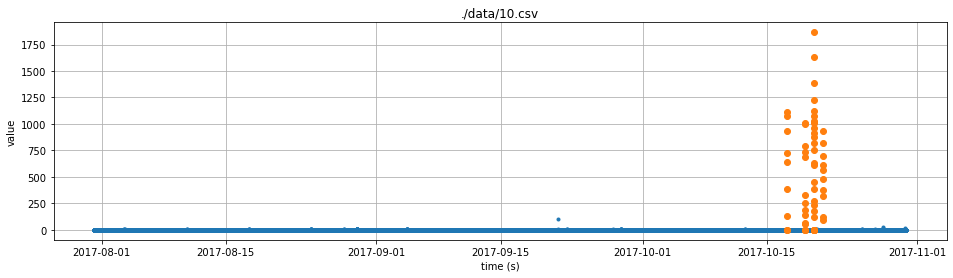

11: 6a757df4-95e5-3357-8406-165e2bd49360 period: 60 sec
Total missing values: 639/110876
Longest missing interval: 2, 53, avreage interval 15.585365853658537


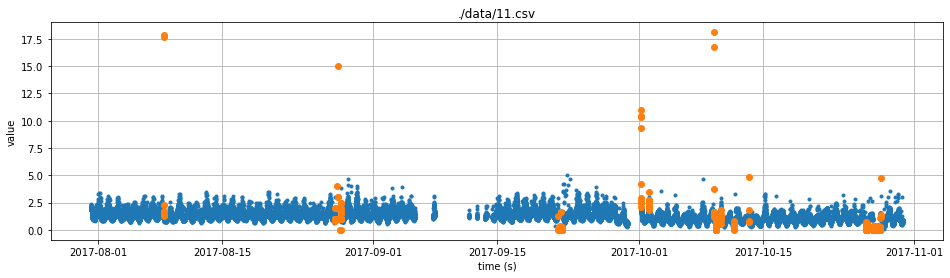

Total missing values: 0


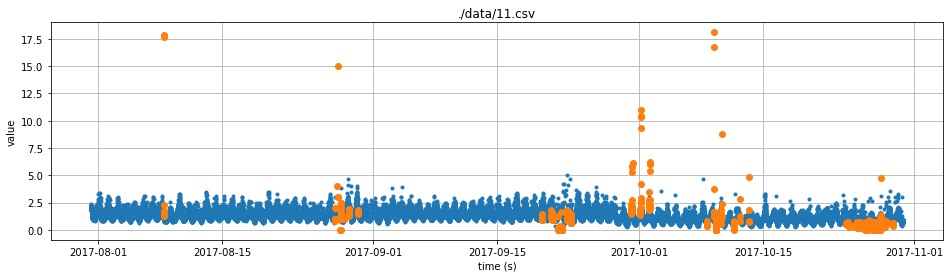

12: 6d1114ae-be04-3c46-b5aa-be1a003a57cd period: 60 sec
Total missing values: 363/149122
Longest missing interval: 2, 7, avreage interval 2.098265895953757


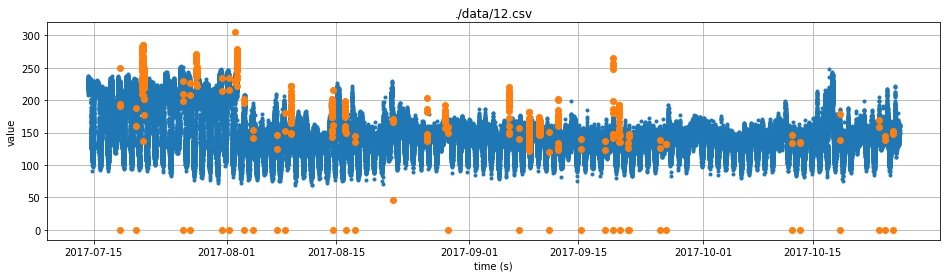

Total missing values: 0


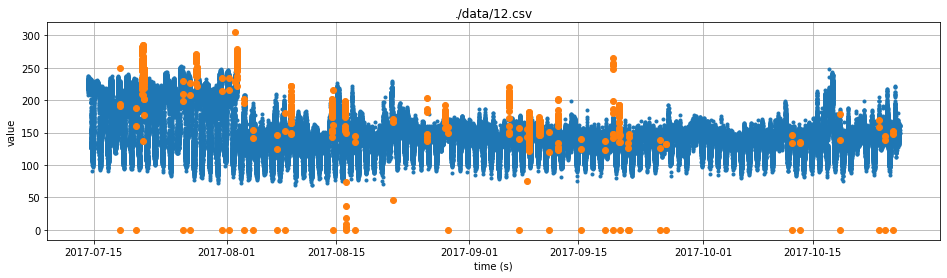

13: 6efa3a07-4544-34a0-b921-a155bd1a05e8 period: 60 sec
Total missing values: 344/149148
Longest missing interval: 2, 6, avreage interval 2.0476190476190474


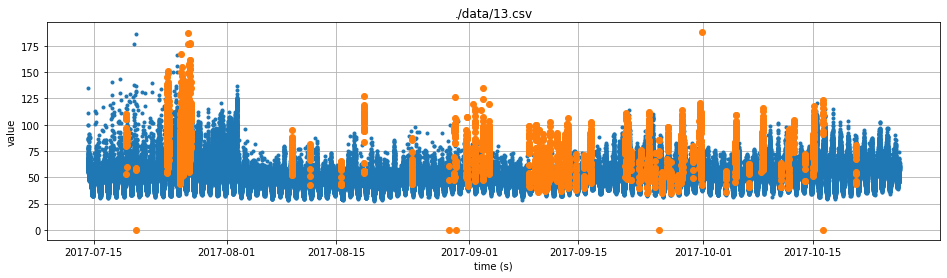

Total missing values: 0


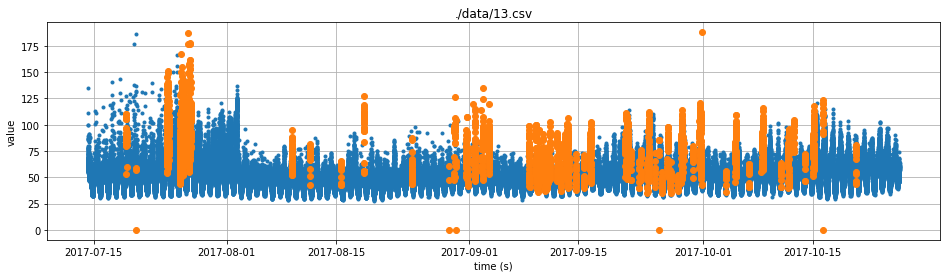

14: 7103fa0f-cac4-314f-addc-866190247439 period: 60 sec
Total missing values: 15972/108425
Longest missing interval: 2, 5421, avreage interval 63.633466135458164


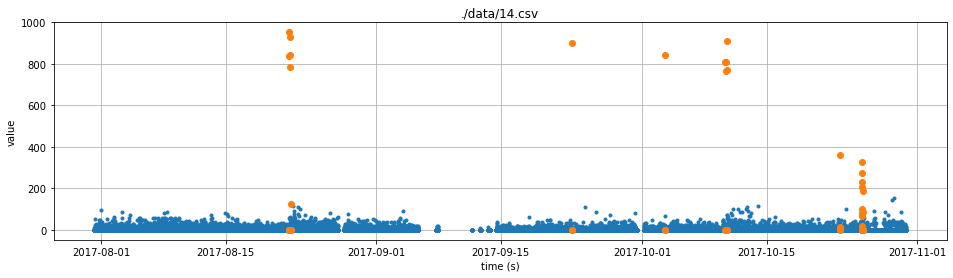

Total missing values: 0


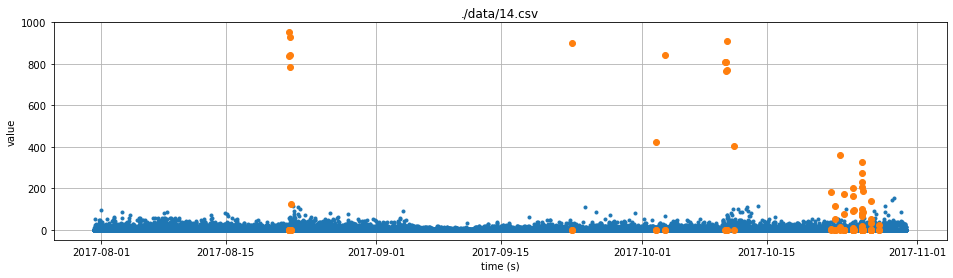

15: 847e8ecc-f8d2-3a93-9107-f367a0aab37d period: 60 sec
Total missing values: 353/149123
Longest missing interval: 2, 7, avreage interval 2.0764705882352943


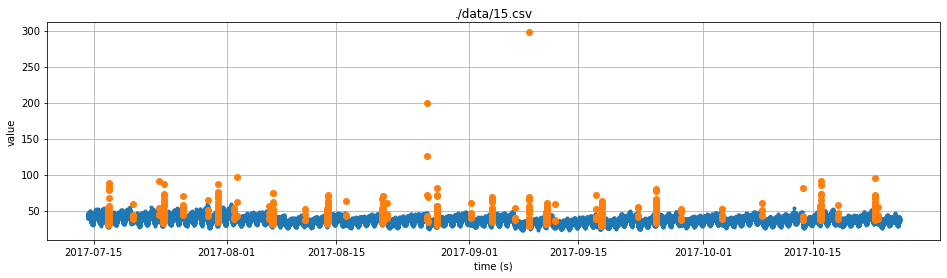

Total missing values: 0


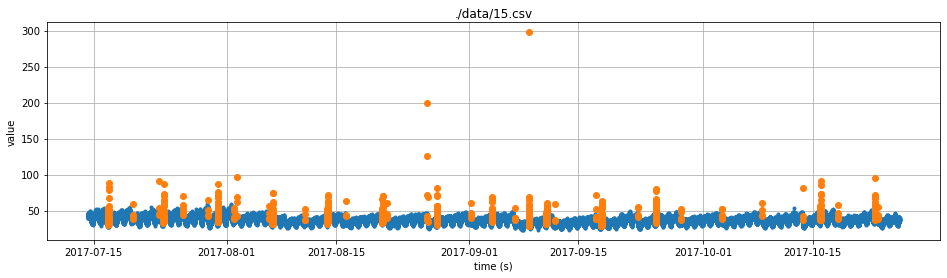

16: 8723f0fb-eaef-32e6-b372-6034c9c04b80 period: 60 sec
Total missing values: 375/149118
Longest missing interval: 2, 35, avreage interval 2.3006134969325154


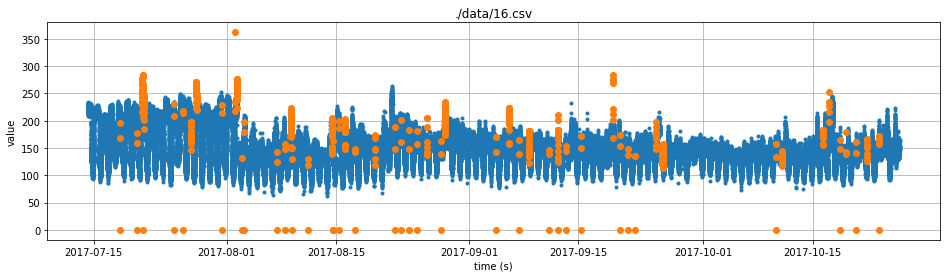

Total missing values: 0


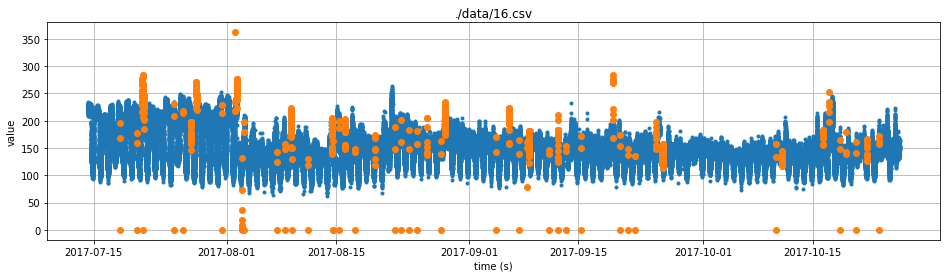

17: 9c639a46-34c8-39bc-aaf0-9144b37adfc8 period: 60 sec
Total missing values: 49/110636
Longest missing interval: 2, 7, avreage interval 2.7222222222222223


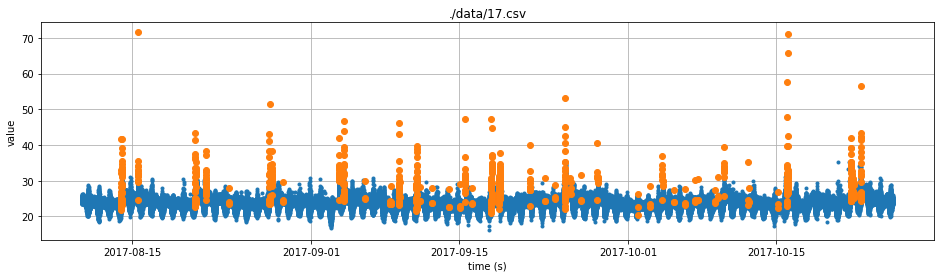

Total missing values: 0


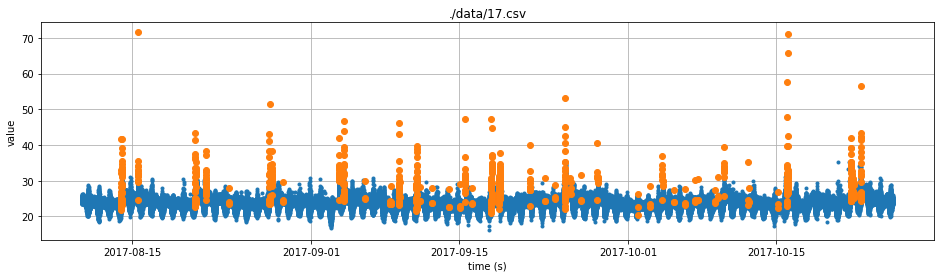

18: a07ac296-de40-3a7c-8df3-91f642cc14d0 period: 60 sec
Total missing values: 50/111307
Longest missing interval: 2, 6, avreage interval 2.272727272727273


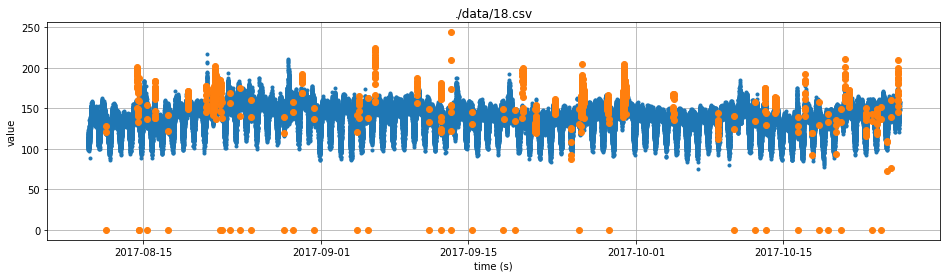

Total missing values: 0


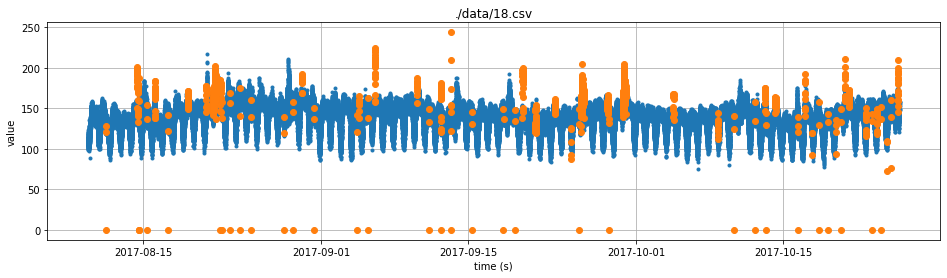

19: a8c06b47-cc41-3738-9110-12df0ee4c721 period: 300 sec
20: ab216663-dcc2-3a24-b1ee-2c3e550e06c9 period: 300 sec
21: adb2fde9-8589-3f5b-a410-5fe14386c7af period: 60 sec
Total missing values: 352/149155
Longest missing interval: 2, 7, avreage interval 2.0584795321637426


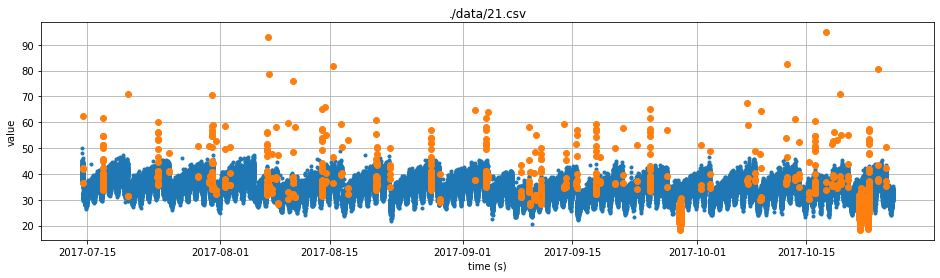

Total missing values: 0


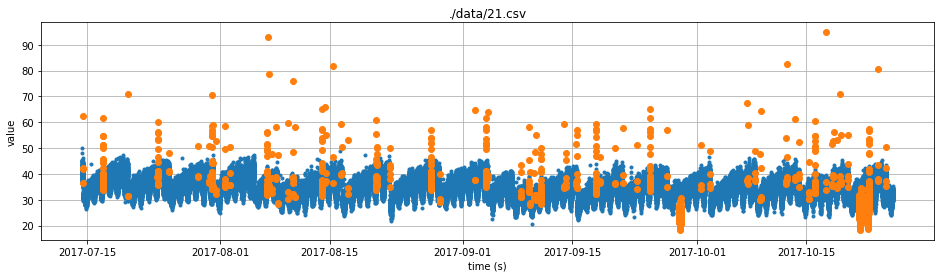

22: ba5f3328-9f3f-3ff5-a683-84437d16d554 period: 60 sec
Total missing values: 334/149132
Longest missing interval: 2, 4, avreage interval 2.0875


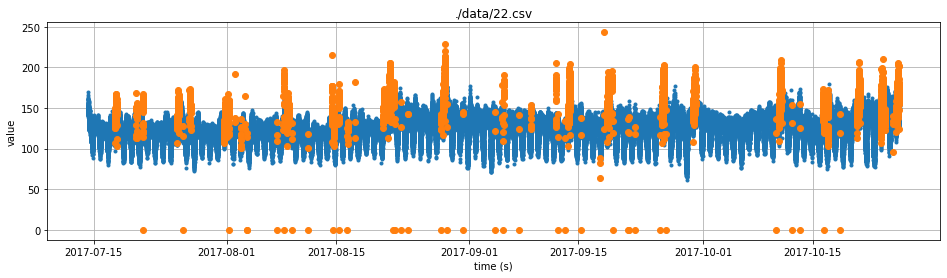

Total missing values: 0


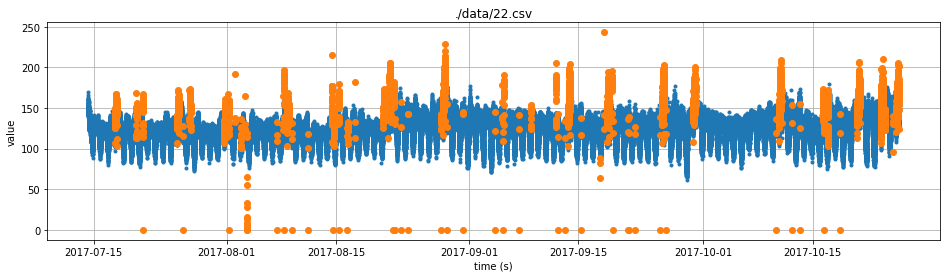

23: c02607e8-7399-3dde-9d28-8a8da5e5d251 period: 300 sec
24: c69a50cf-ee03-3bd7-831e-407d36c7ee91 period: 60 sec
Total missing values: 348/149159
Longest missing interval: 2, 7, avreage interval 2.0838323353293413


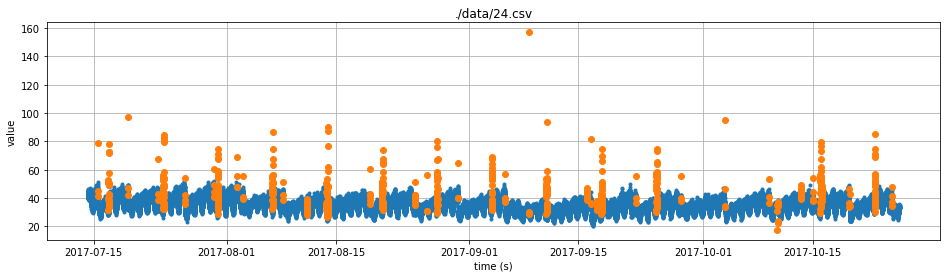

Total missing values: 0


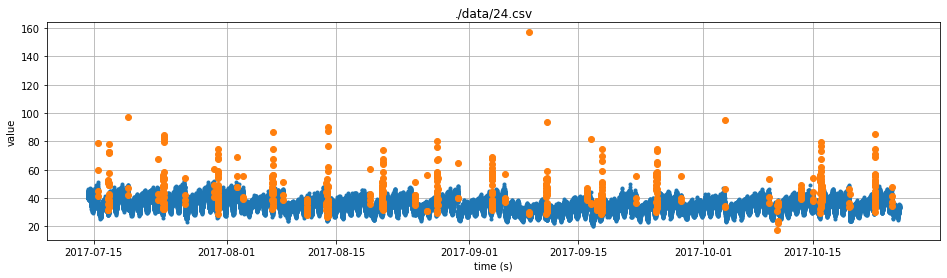

25: da10a69f-d836-3baa-ad40-3e548ecf1fbd period: 60 sec
Total missing values: 795/107167
Longest missing interval: 2, 7, avreage interval 2.1087533156498672


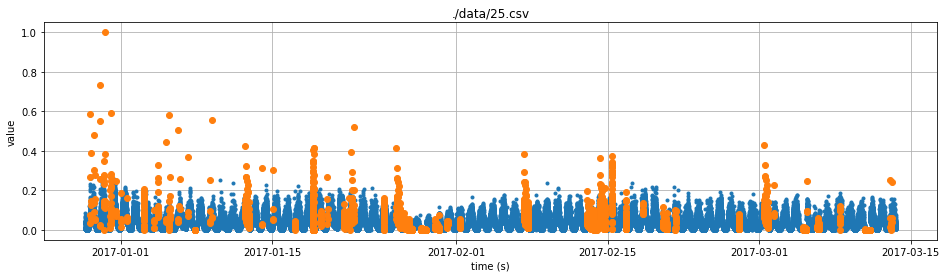

Total missing values: 0


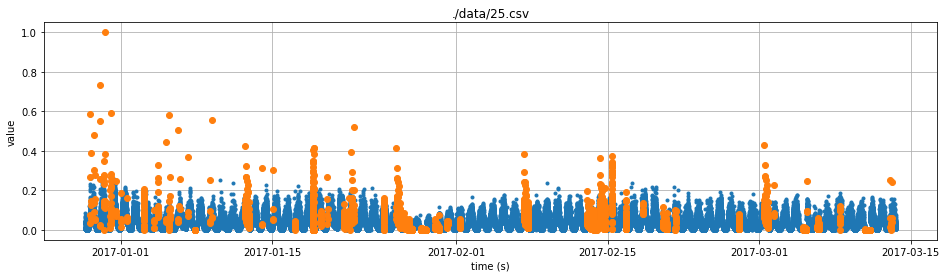

26: e0747cad-8dc8-38a9-a9ab-855b61f5551d period: 300 sec
27: f0932edd-6400-3e63-9559-0a9860a1baa9 period: 60 sec
Total missing values: 16216/112149
Longest missing interval: 2, 5421, avreage interval 64.60557768924303


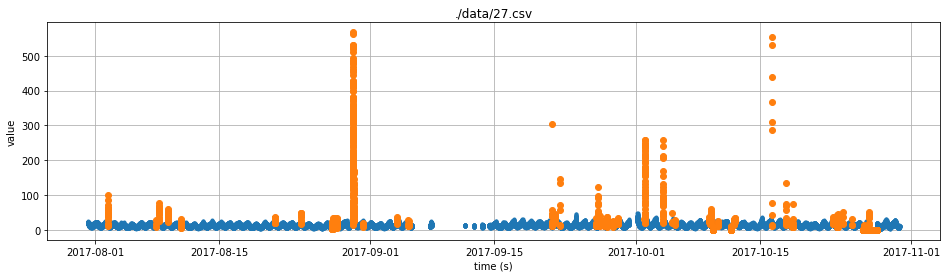

Total missing values: 0


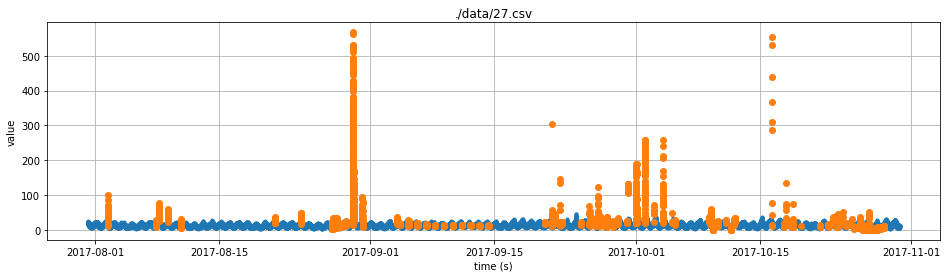

28: ffb82d38-5f00-37db-abc0-5d2e4e4cb6aa period: 60 sec
Total missing values: 16500/111396
Longest missing interval: 2, 5421, avreage interval 44.71544715447155


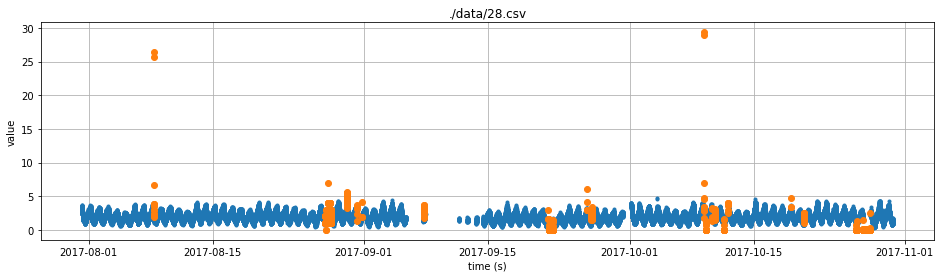

Total missing values: 0


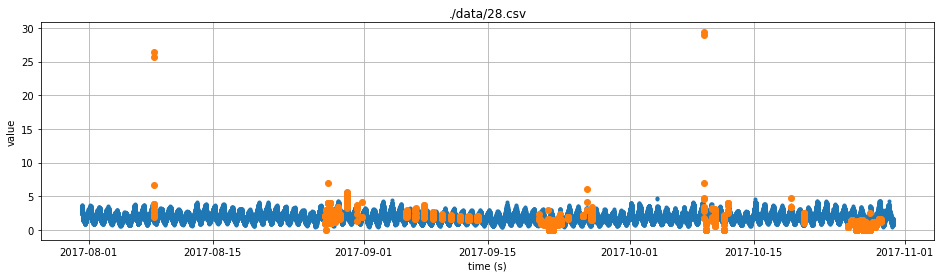

In [41]:
num = 1
files = []
for num in range(len(uuids)):
    uuid = uuids.index[num]
    df0 = df[df['KPI ID'] == uuid]
    period = df0.timestamp.values[1] - df0.timestamp.values[0]
    print(f'{num}: {uuid} period: {period} sec')
    if (period > 60):
        continue
    missing_intervals, missing_intervals_len = check_missing_timestamp(df0)
    print(f'Total missing values: {sum(missing_intervals_len)}/{len(df0)}')
    print(f'Longest missing interval: {min(missing_intervals_len)}, {max(missing_intervals_len)}, avreage interval {np.mean(missing_intervals_len)}')
    idx = pd.to_datetime(df0['timestamp'].apply(lambda x: pd.Timestamp(x, unit='s')))
    df1 = df0.set_index(idx).loc[:,['value', 'label', 'KPI ID']].resample('1min').asfreq()#.fillna(0)
    plot_anomaly(df1, num)
    df2 = impute(df1)
    print(f'Total missing values: {df2.value.isnull().sum()}')
    plot_anomaly(df2, num)
    files.append(f'./data/{num}.csv')
    df2.to_csv(f'./data/{num}.csv', sep=',')
    num += 1


In [39]:
files

['./data/0.csv',
 './data/2.csv',
 './data/4.csv',
 './data/5.csv',
 './data/6.csv',
 './data/7.csv',
 './data/9.csv',
 './data/10.csv',
 './data/11.csv',
 './data/12.csv',
 './data/13.csv',
 './data/14.csv',
 './data/15.csv',
 './data/16.csv',
 './data/17.csv',
 './data/18.csv',
 './data/21.csv',
 './data/22.csv',
 './data/24.csv',
 './data/25.csv',
 './data/27.csv',
 './data/28.csv']